# Reduction

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.compose import ReducedRegressionForecaster
from sktime.performance_metrics.forecasting import smape_loss
from sktime.utils.plotting.forecasting import plot_ys
import matplotlib.pyplot as plt

In [2]:
from sktime.datasets import load_airline

## Data

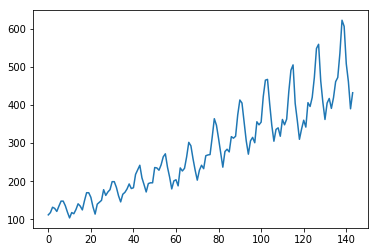

In [3]:
airline = load_airline()
plt.plot(airline)

## Sklearn approach

### Prepare Dataset

In [4]:
features = []
target = []
for i in range(len(airline)-10):
    features.append(airline[i:i+10])
    target.append(airline[i+10])
features = np.array(features)
target = np.array(target)

In [5]:
airline[:15]

0     112.0
1     118.0
2     132.0
3     129.0
4     121.0
5     135.0
6     148.0
7     148.0
8     136.0
9     119.0
10    104.0
11    118.0
12    115.0
13    126.0
14    141.0
Name: Airline, dtype: float64

In [6]:
features

array([[112., 118., 132., ..., 148., 136., 119.],
       [118., 132., 129., ..., 136., 119., 104.],
       [132., 129., 121., ..., 119., 104., 118.],
       ...,
       [405., 417., 391., ..., 622., 606., 508.],
       [417., 391., 419., ..., 606., 508., 461.],
       [391., 419., 461., ..., 508., 461., 390.]])

In [7]:
target

array([104., 118., 115., 126., 141., 135., 125., 149., 170., 170., 158.,
       133., 114., 140., 145., 150., 178., 163., 172., 178., 199., 199.,
       184., 162., 146., 166., 171., 180., 193., 181., 183., 218., 230.,
       242., 209., 191., 172., 194., 196., 196., 236., 235., 229., 243.,
       264., 272., 237., 211., 180., 201., 204., 188., 235., 227., 234.,
       264., 302., 293., 259., 229., 203., 229., 242., 233., 267., 269.,
       270., 315., 364., 347., 312., 274., 237., 278., 284., 277., 317.,
       313., 318., 374., 413., 405., 355., 306., 271., 306., 315., 301.,
       356., 348., 355., 422., 465., 467., 404., 347., 305., 336., 340.,
       318., 362., 348., 363., 435., 491., 505., 404., 359., 310., 337.,
       360., 342., 406., 396., 420., 472., 548., 559., 463., 407., 362.,
       405., 417., 391., 419., 461., 472., 535., 622., 606., 508., 461.,
       390., 432.])

In [8]:
features.shape

(134, 10)

### Train Test Split

In [9]:
TRAIN_RATIO = 0.8

In [10]:
train_shape = int(features.shape[0] * 0.8)

In [11]:
features_train = features[:train_shape]
target_train = target[:train_shape]
features_test = features[train_shape:]
target_test = target[train_shape:]

In [12]:
[x.shape for x in [features_train,features_test,target_train,target_test]]

[(107, 10), (27, 10), (107,), (27,)]

### Train Regressor

In [13]:
from sklearn.ensemble import RandomForestRegressor

In [14]:
regr = RandomForestRegressor()
regr.fit(features_train,target_train)

RandomForestRegressor()

In [15]:
y_preds = regr.predict(features_test)

In [16]:
size1 = target_train.shape[0]
size2 = target_test.shape[0]

y_train = pd.Series(target_train)
y_test = pd.Series(target_test,index=range(size1,size1 + size2))
y_pred = pd.Series(y_preds,index=range(size1,size1 + size2))

In [17]:
smape_loss(y_test,y_pred)

0.10043865157438578

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1eb8987b4e0>)

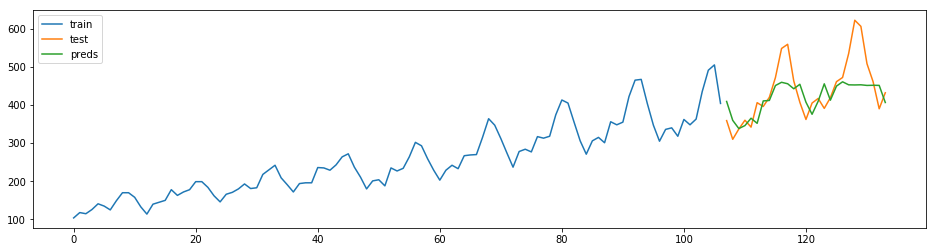

In [18]:
plot_ys(y_train,y_test,y_pred,labels=['train','test','preds'])

### Additional Time Series Summarizing Features

In [19]:
df_train = pd.DataFrame(features_train).assign(
    mean = lambda x : x.mean(axis=1),
    median = lambda x : x.median(axis=1),
    std = lambda x : x.std(axis=1))

df_test = pd.DataFrame(features_test).assign(
    mean = lambda x : x.mean(axis=1),
    median = lambda x : x.median(axis=1),
    std = lambda x : x.std(axis=1))

In [20]:
regr = RandomForestRegressor()
regr.fit(df_train,target_train)

RandomForestRegressor()

In [21]:
y_preds = regr.predict(df_test)

In [22]:
size1 = target_train.shape[0]
size2 = target_test.shape[0]

y_train = pd.Series(target_train)
y_test = pd.Series(target_test,index=range(size1,size1 + size2))
y_pred = pd.Series(y_preds,index=range(size1,size1 + size2))

In [23]:
smape_loss(y_test,y_pred)

0.100608802013589

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1eb89e44588>)

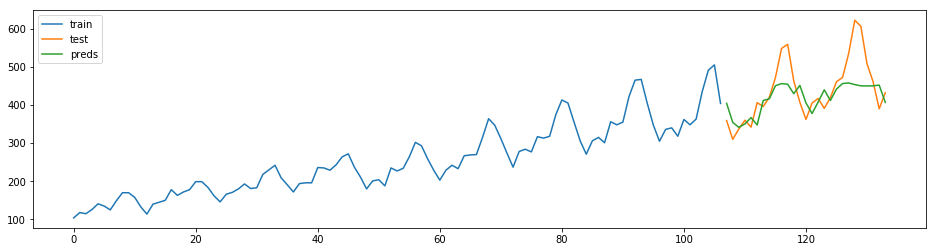

In [24]:
plot_ys(y_train,y_test,y_pred,labels=['train','test','preds'])

### Evaluate Different Regressors

In [25]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [26]:
listOfRegressors = [SVR(),DecisionTreeRegressor(),KNeighborsRegressor(10),LinearRegression(),
                    RandomForestRegressor(),ExtraTreesRegressor(),
                    XGBRegressor(),LGBMRegressor(),CatBoostRegressor(iterations=100,verbose=3)]

[18:33:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Learning rate set to 0.15088
0:	learn: 82.3326151	total: 53.6ms	remaining: 5.3s
3:	learn: 63.1035019	total: 62.6ms	remaining: 1.5s
6:	learn: 48.7163081	total: 70.8ms	remaining: 941ms
9:	learn: 39.9198686	total: 79.3ms	remaining: 713ms
12:	learn: 34.1677641	total: 82.7ms	remaining: 554ms
15:	learn: 30.2027159	total: 86.4ms	remaining: 454ms
18:	learn: 27.2193111	total: 90.3ms	remaining: 385ms
21:	learn: 24.9325396	total: 93.9ms	remaining: 333ms
24:	learn: 23.0346548	total: 97.8ms	remaining: 293ms
27:	learn: 21.7098592	total: 102ms	remaining: 263ms
30:	learn: 20.5144501	total: 106ms	remaining: 237ms
33:	learn: 19.2998782	total: 110ms	remaining: 214ms
36:	learn: 18.0552566	total: 114ms	remaining: 194ms
39:	learn: 16.8452324	total: 119ms	remaining: 178ms
42:	learn: 15.7700078	total: 130ms	remaining: 173ms
45:	learn: 14.8386296	to

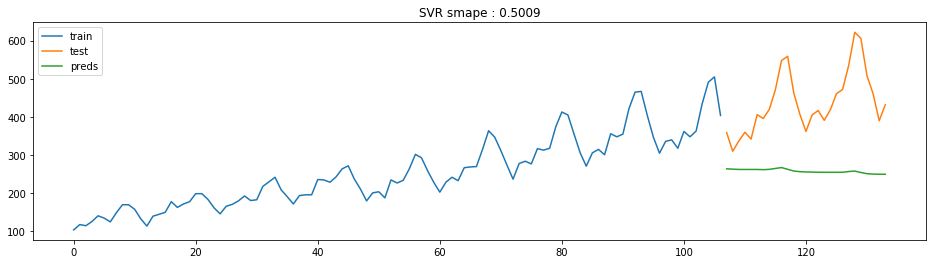

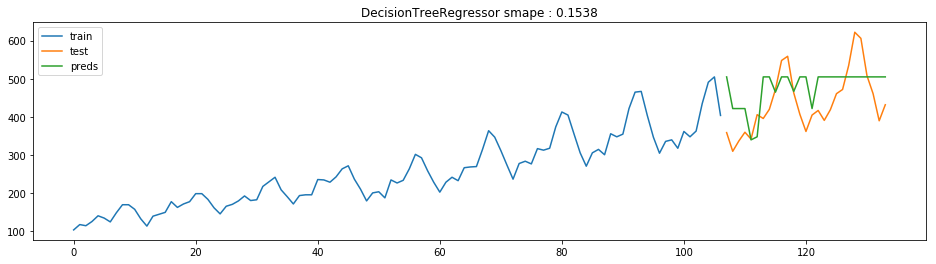

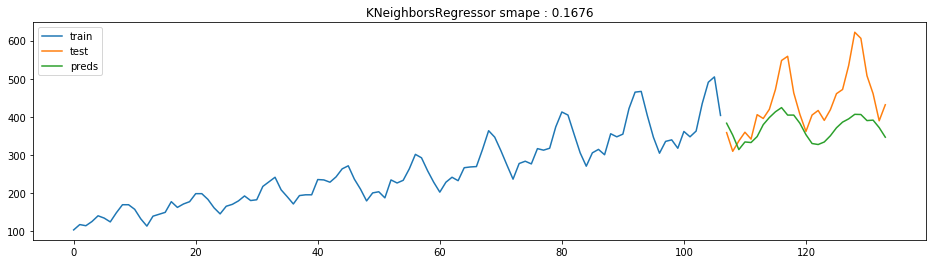

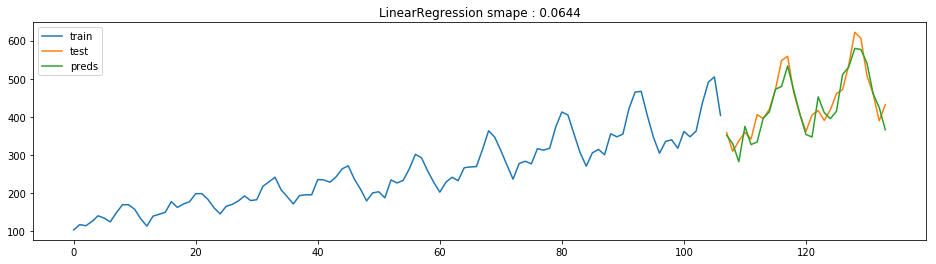

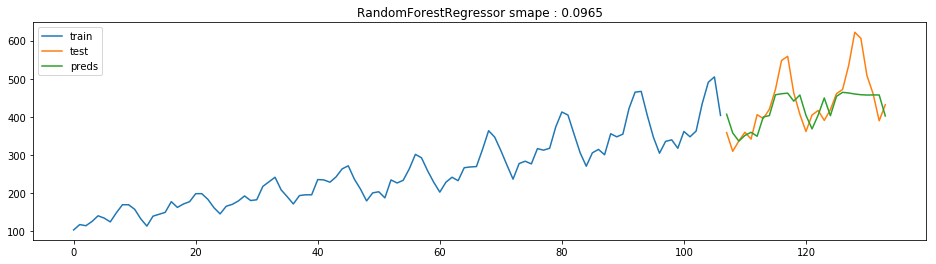

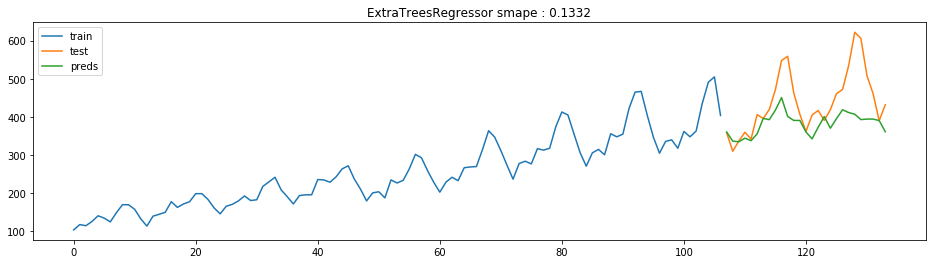

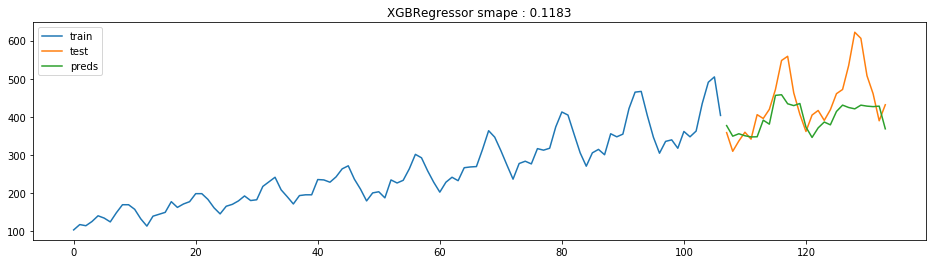

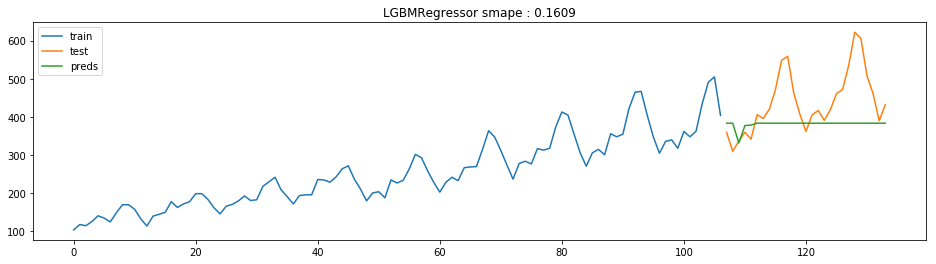

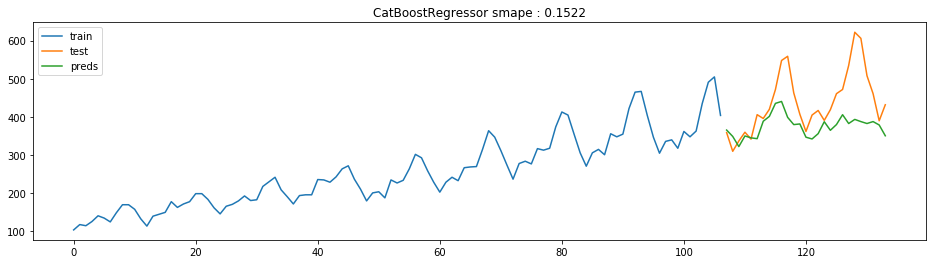

In [27]:
results = {}
for r in listOfRegressors:
    regr = r
    regr.fit(df_train,target_train)
    
    y_preds = regr.predict(df_test)
    
    size1 = target_train.shape[0]
    size2 = target_test.shape[0]
    y_train = pd.Series(target_train)
    y_test = pd.Series(target_test,index=range(size1,size1 + size2))
    y_pred = pd.Series(y_preds,index=range(size1,size1 + size2))
    results[r.__class__.__name__] = smape_loss(y_test,y_pred)
    
    plot_ys(y_train,y_test,y_pred,labels=['train','test','preds'])
    plt.title(f'{r.__class__.__name__} smape : {round(smape_loss(y_test,y_pred),4)}')

In [28]:
pd.DataFrame()\
    .from_dict(results, orient='index')\
    .rename_axis('Regressor')\
    .rename(columns={0: 'smape_loss'})\
    .sort_values(by='smape_loss', ascending=True)

,smape_loss
Regressor,
LinearRegression,0.064419
RandomForestRegressor,0.096522
XGBRegressor,0.118268
ExtraTreesRegressor,0.133177
CatBoostRegressor,0.152199
DecisionTreeRegressor,0.153767
LGBMRegressor,0.160873
KNeighborsRegressor,0.167582
SVR,0.500948


## Sktime Approach

### Train Test Split with temporal_train_test_split

In [29]:
TEST_SIZE = 27
y_train, y_test = temporal_train_test_split(airline, test_size = TEST_SIZE)
[x.shape for x in [y_train, y_test]]

[(117,), (27,)]

### ReducedRegressionForecaster

In [30]:
regressor = RandomForestRegressor(n_estimators=500)
rdcd_regr = ReducedRegressionForecaster(regressor, window_length=10)

In [31]:
rdcd_regr.fit(y_train)

RecursiveRegressionForecaster(regressor=RandomForestRegressor(n_estimators=500))

In [32]:
fh = np.arange(1,TEST_SIZE+1)

In [33]:
y_pred = rdcd_regr.predict(fh)

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1eb973479b0>)

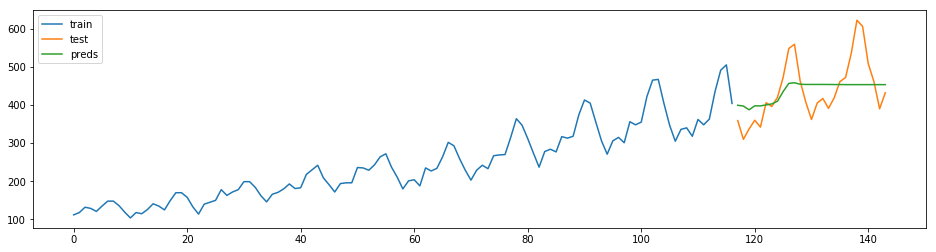

In [34]:
plot_ys(y_train,y_test,y_pred,labels=['train','test','preds'])

### Evaluate Different Regressors

In [35]:
fh = np.arange(1,TEST_SIZE+1)

[18:33:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Learning rate set to 0.15088
0:	learn: 82.8234038	total: 2.17ms	remaining: 215ms
3:	learn: 62.4488269	total: 5.42ms	remaining: 130ms
6:	learn: 49.0541854	total: 8.81ms	remaining: 117ms
9:	learn: 39.3808848	total: 11.9ms	remaining: 107ms
12:	learn: 34.0110543	total: 15.1ms	remaining: 101ms
15:	learn: 29.7196163	total: 18.4ms	remaining: 96.8ms
18:	learn: 26.3984057	total: 21.6ms	remaining: 92.1ms
21:	learn: 24.1272375	total: 24.6ms	remaining: 87.2ms
24:	learn: 22.6459142	total: 27.9ms	remaining: 83.7ms
27:	learn: 21.1706720	total: 31ms	remaining: 79.8ms
30:	learn: 19.9867663	total: 35.6ms	remaining: 79.3ms
33:	learn: 18.6157582	total: 38.4ms	remaining: 74.4ms
36:	learn: 17.4801837	total: 41.1ms	remaining: 70ms
39:	learn: 16.3313047	total: 44ms	remaining: 66ms
42:	learn: 15.0496497	total: 48ms	remaining: 63.6ms
45:	learn: 14.11

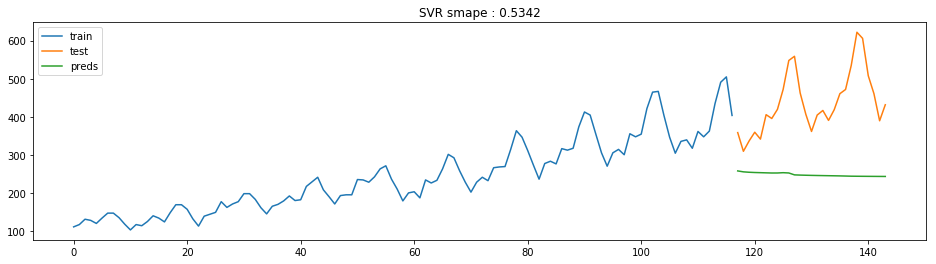

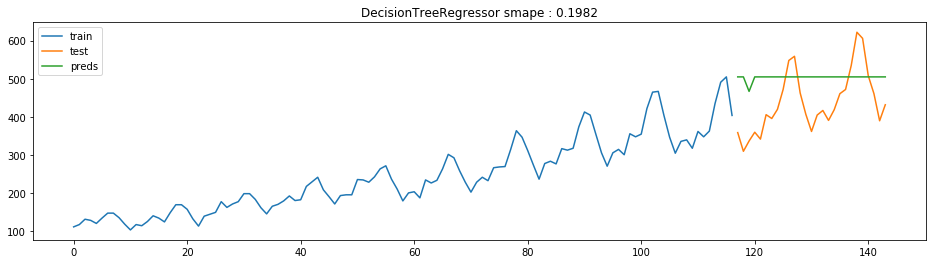

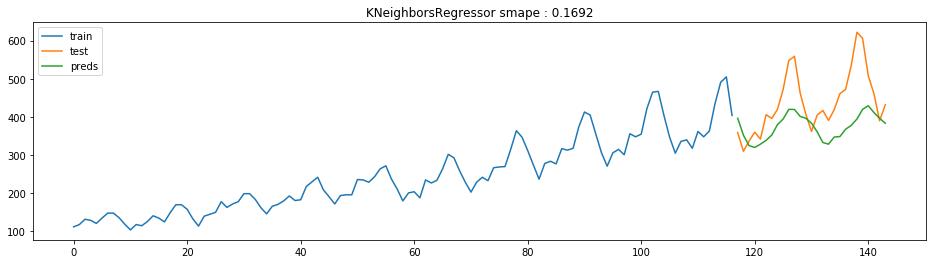

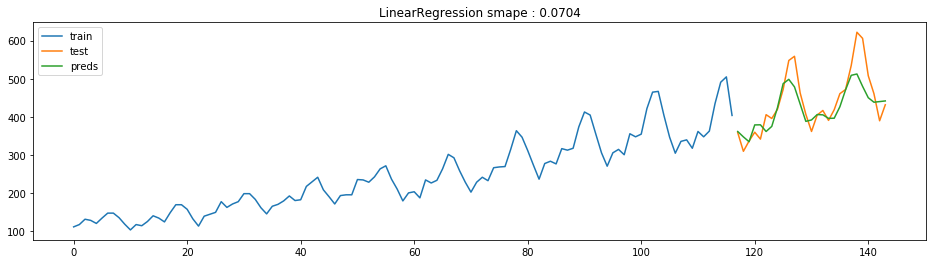

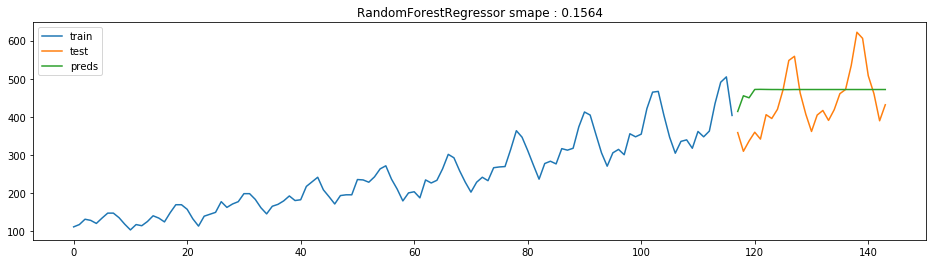

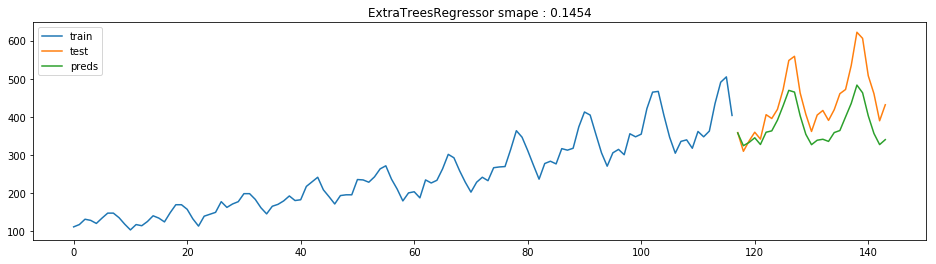

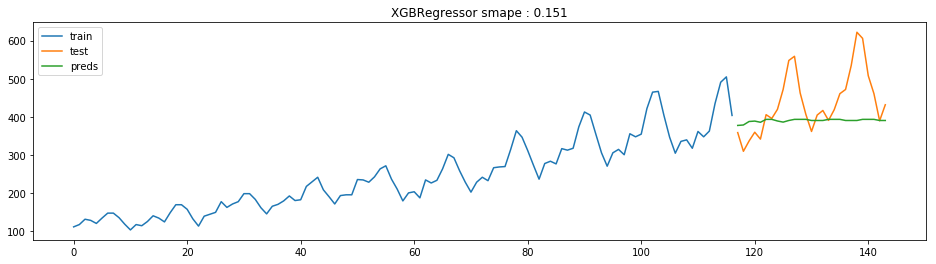

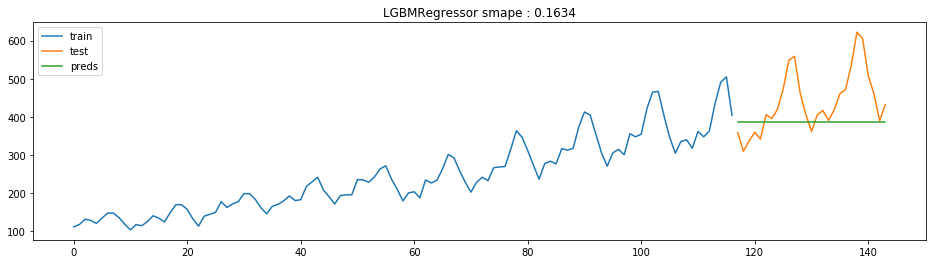

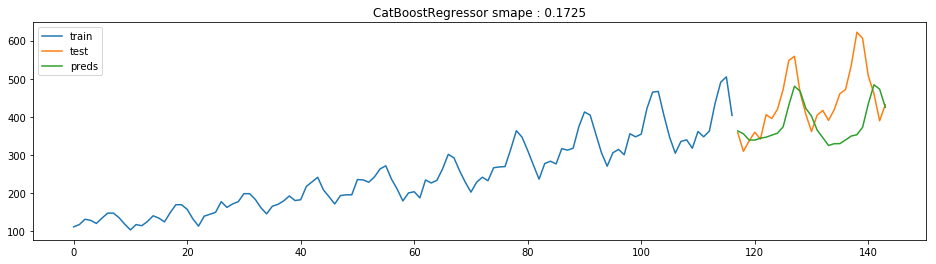

In [36]:
results = {}
for r in listOfRegressors:
#     print(r.__class__.__name__)
    regressor = r
    rdcd_regr = ReducedRegressionForecaster(regressor, window_length=10)
    rdcd_regr.fit(y_train)
    y_pred = rdcd_regr.predict(fh)
    results[r.__class__.__name__] = smape_loss(y_test,y_pred)
#     print(smape_loss(y_test,y_pred))
    plot_ys(y_train,y_test,y_pred,labels=['train','test','preds'])
    plt.title(f'{r.__class__.__name__} smape : {round(smape_loss(y_test,y_pred),4)}')

In [37]:
pd.DataFrame()\
    .from_dict(results, orient='index')\
    .rename_axis('Regressor')\
    .rename(columns={0: 'smape_loss'})\
    .sort_values(by='smape_loss', ascending=True)

,smape_loss
Regressor,
LinearRegression,0.070438
ExtraTreesRegressor,0.145372
XGBRegressor,0.151021
RandomForestRegressor,0.156378
LGBMRegressor,0.163379
KNeighborsRegressor,0.169171
CatBoostRegressor,0.172541
DecisionTreeRegressor,0.198233
SVR,0.534202
